<a href="https://colab.research.google.com/github/mou58/burn_injury_classification/blob/master/resnet50_onehot_burn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization 
from tensorflow.keras.layers import Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import datasets
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import random
from datetime import datetime
import pandas as pd

%matplotlib inline

## Implement the model

In [ ]:
def conv_block(input, filters:int, kernel_size:tuple=(1,1), strides:tuple=(1,1), 
               padding:str='valid', bn_axis:int=3, activation:str=None):
    
    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)(input)
    x = BatchNormalization(axis=bn_axis)(x)
    
    if activation is not None:
        x = Activation(activation)(x)
    
    return x

def resnet_block(input, filters:list, kernel_size:tuple=(3,3), strides:tuple=(1,1), convolutional:bool=False):
    
    x_shortcut = input
    
    x = conv_block(input, filters[0], (1,1), strides, 'valid', 3, 'relu')
    x = conv_block(x, filters[1], kernel_size, (1,1), 'same', 3, 'relu')    
    x = conv_block(x, filters[2], (1,1), (1,1), 'valid', 3, None) 
    
    if convolutional: x_shortcut = conv_block(input, filters[2], (1,1), strides, 'valid', 3, None)
        
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

def resnet50(input_shape, n_classes, aug=None):
    
    input = Input(input_shape)

    # Stage 0: zero-padding
    if aug is not None: # with augmentation
      x = aug(input)
      x = ZeroPadding2D((3, 3))(x) 
    else: x = ZeroPadding2D((3, 3))(input) # without augmentation
        
    # Stage 1
    x = conv_block(x, 64, (7,7), (2,2), 'valid', 3, 'relu')    
    x = MaxPooling2D((3,3), strides=(2,2))(x)
    
    # Stage 2
    x = resnet_block(x, [64,64,256], (3,3), (1,1), True)
    x = resnet_block(x, [64,64,256], (3,3), (1,1), False)
    x = resnet_block(x, [64,64,256], (3,3), (1,1), False)
    
    # Stage 3
    x = resnet_block(x, [128,128,512], (3,3), (2,2), True)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    x = resnet_block(x, [128,128,512], (3,3), (1,1), False)
    
    # Stage 4
    x = resnet_block(x, [256,256,1024], (3,3), (2,2), True)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    x = resnet_block(x, [256,256,1024], (3,3), (1,1), False)
    
    # Stage 5
    x = resnet_block(x, [512,512,2048], (3,3), (2,2), True)
    x = resnet_block(x, [512,512,2048], (3,3), (1,1), False) 
    x = resnet_block(x, [512,512,2048], (3,3), (1,1), False) 
    
    # Stage 6: Average pooling
    x = AveragePooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(n_classes, activation='softmax', name='fc')(x)

    # Create model
    model = Model(inputs=input, outputs=x, name='ResNet50')

    return model


## Prepare dataset

In [ ]:
# Preprocessing
# This function creates image dataset after preprocessing images. Image can be grayscale or rgb
def create_image_data(CATEGORIES, img_size, dimension, DataDir):
    database = []
    for category in CATEGORIES:
        print(category)
        path = os.path.join(DataDir, category)
        class_num = CATEGORIES.index(category)
        for img_name in tqdm(os.listdir(path)):
            try:
                if dimension == 1:
                    img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
                elif dimension == 3:
                    img = cv2.imread(os.path.join(path, img_name))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                else:
                    print('Please select dimension either 1 or 3')
                img = cv2.resize(img, (img_size, img_size))
                database.append([img, class_num])
            except Exception as e:
                pass
    return database

In [ ]:
# Preprocessing
# This function preprocess single image
def prepare(filepath, IMG_SIZE, dimension):
    if dimension == 1:
        img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    elif dimension == 3:
        img_array = cv2.imread(filepath)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    else:
        print("Please select dimension either 1 or 3")
    new_array = new_array.reshape(-1, IMG_SIZE, IMG_SIZE, dimension)
    return new_array

In [ ]:
IMG_SIZE = 200
DIM = 3
CATEGORIES = ["superficial", "deep", "full"]

n_classes = len(CATEGORIES)

TRAINDIR = '/content/drive/MyDrive/CSC 514/Burns_BIP_US_database/Training set'
TESTDIR = '/content/drive/MyDrive/CSC 514/Burns_BIP_US_database/Test'

In [ ]:
# Create training dataset
training_data = create_image_data(CATEGORIES, IMG_SIZE, DIM, TRAINDIR)

# Randomize the dataset
random.shuffle(training_data)

XF = [] # XF will contain training image data
yF = []# yF will contain corresponding image class

for features,label in training_data:
    XF.append(features)
    yF.append(label)

XF = np.array(XF).reshape(-1, IMG_SIZE, IMG_SIZE, DIM)
print("\nShape of the training data", XF.shape)

# Normalize data
# XF2 = XF/255.0

yF = np.array(yF)
print('Training labels', yF)

superficial


100%|██████████| 9/9 [00:08<00:00,  1.10it/s]


deep


100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


full


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Shape of the training data (20, 200, 200, 3)
Training labels [1 2 1 0 0 0 0 2 2 0 2 0 1 2 1 0 0 1 0 2]


In [ ]:
# Create testing dataset
testing_data = create_image_data(CATEGORIES, IMG_SIZE, DIM, TESTDIR)

# Randomize the dataset
random.shuffle(testing_data)

Xt = []
yt = []

for features,label in testing_data:
    Xt.append(features)
    yt.append(label)

Xt = np.array(Xt).reshape(-1, IMG_SIZE, IMG_SIZE, DIM)
print("Shape Xt", Xt.shape)

yt = np.array(yt)
print(yt)

# Xt = Xt/255.0

superficial


100%|██████████| 33/33 [00:21<00:00,  1.54it/s]


deep


100%|██████████| 27/27 [00:16<00:00,  1.65it/s]


full


100%|██████████| 14/14 [00:08<00:00,  1.61it/s]

Shape Xt (74, 200, 200, 3)
[1 2 2 0 1 0 1 2 0 1 0 1 0 1 1 0 0 0 1 2 2 1 1 2 0 1 1 1 2 0 1 0 1 0 0 2 0
 2 0 1 0 0 1 1 1 2 1 0 0 2 0 1 2 2 1 1 0 1 0 0 0 0 2 0 0 0 0 1 1 0 0 1 0 0]


## Visualize samples

Text(0.5, 1.0, 'superficial')

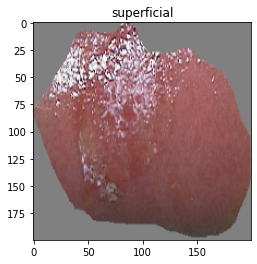

In [ ]:
idx = int(np.random.randint(low=0, high=len(XF), size=1)) # randomly choose an integer

plt.figure(figsize=(4,4))
plt.imshow(np.squeeze(XF[idx]))
plt.title(CATEGORIES[yF[idx]])

## Convert to onehot

In [ ]:
yF = tf.keras.utils.to_categorical(yF, num_classes=n_classes)
yt_onehot = tf.keras.utils.to_categorical(yt, num_classes=n_classes)

## Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2),
      # layers.RandomZoom(0.2),
    ]
  )

In [ ]:
# XF = XF/255.0
# Xt = Xt/255.0

XF = tf.keras.applications.resnet50.preprocess_input(XF)
Xt = tf.keras.applications.resnet50.preprocess_input(Xt)

## Build model

In [ ]:
model_name = 'resnet50' + '_' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

print(model_name)

resnet50_2022-12-07_20-50-29


In [ ]:
model = resnet50(input_shape=XF.shape[1:], n_classes=n_classes, aug=None)  

In [ ]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 206, 206, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

## Compile model

In [ ]:
loss = 'categorical_crossentropy'

metrics = ['accuracy']

model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-5), metrics=metrics)

checkpoint_loc = '/content/drive/MyDrive/CSC 514/checkpoints/' + model_name
log_path = "/content/drive/MyDrive/CSC 514/logs/"

# Create checkpoint directory if does not exist
if not os.path.exists(checkpoint_loc): os.makedirs(checkpoint_loc)
if not os.path.exists(log_path): os.makedirs(log_path)

checkpoint_path = os.path.join(checkpoint_loc, 'best_model.h5')

checkpoint_dir = os.path.dirname(checkpoint_path)

# monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=1, mode='auto',
#         restore_best_weights=True)

callbacks = [
    # tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1),
    
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1,
                      monitor='val_loss',
                      patience=10,
                      min_lr=0.00001,
                      verbose=1,
                      mode='auto'),
    
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                      monitor = 'val_loss',
                      verbose = 1,
                      save_best_only=True,
                      save_weights_only=True,
                      ),
    tf.keras.callbacks.CSVLogger(os.path.join(log_path, model_name + '.csv'), separator=',', append=True),
]


In [ ]:
# Uncomment to load the model
# model = resnet50(input_shape=XF.shape[1:], n_classes=n_classes)  
# model.load_weights(checkpoint_loc + '//' + 'best_model.h5')
# model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-5), metrics=metrics)

## Train model

In [ ]:
history = model.fit(x=XF,
                    y=yF,
                    batch_size=4,
                    epochs=1000,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks,
                    shuffle = True,  
                    )

Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 2.2005 - accuracy: 0.2778
Epoch 1: val_loss improved from inf to 1.11273, saving model to /content/drive/MyDrive/CSC 514/checkpoints/resnet50_2022-12-07_20-50-29/best_model.h5
5/5 [==============================] - 17s 655ms/step - loss: 2.2005 - accuracy: 0.2778 - val_loss: 1.1127 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 2/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.2335 - accuracy: 0.4375
Epoch 2: val_loss improved from 1.11273 to 1.06157, saving model to /content/drive/MyDrive/CSC 514/checkpoints/resnet50_2022-12-07_20-50-29/best_model.h5
5/5 [==============================] - 1s 211ms/step - loss: 1.3396 - accuracy: 0.3889 - val_loss: 1.0616 - val_accuracy: 0.5000 - lr: 1.0000e-05
Epoch 3/1000
4/5 [=======================>......] - ETA: 0s - loss: 1.2155 - accuracy: 0.4375
Epoch 3: val_loss did not improve from 1.06157
5/5 [==============================] - 0s 67ms/step - loss: 1.2054 - accur

In [ ]:
# Save model
model.save("/content/drive/MyDrive/CSC 514/" + model_name + "_last_model")

## Plot loss and accuracy curve

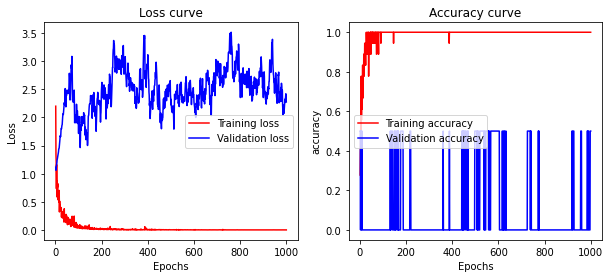

In [ ]:
save_fig_dir = "/content/drive/MyDrive/CSC 514/plots/"
if not os.path.exists(save_fig_dir): os.makedirs(save_fig_dir)

fig, ax = plt.subplots(1,2, figsize=(10,4))
history_dict = history.history

# Plot loss curve
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
ax[0].plot(epochs, loss_values, "r", label="Training loss")
ax[0].plot(epochs, val_loss_values, "b", label="Validation loss")
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# Plot accuracy curve
acc_train = history_dict["accuracy"]
acc_val = history_dict["val_accuracy"]
ax[1].plot(epochs, acc_train, "r", label="Training accuracy")
ax[1].plot(epochs, acc_val, "b", label="Validation accuracy")
ax[1].set_title("Accuracy curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("accuracy")
ax[1].legend()

fig.savefig(os.path.join(save_fig_dir, model_name + '.png'))    

## Load model

In [ ]:
# Uncomment to load the model
# model = resnet50(input_shape=XF.shape[1:], n_classes=n_classes)  
# model.load_weights(checkpoint_loc + '//' + 'best_model.h5') 
# model.compile(loss=loss, optimizer=Adam(learning_rate = 1e-5), metrics=metrics)


# model = tensorflow.keras.models.load_model(model_name + "_last_model")

## Sample test

1/1 [==============================] - 1s 1s/step
Class:  2 deep


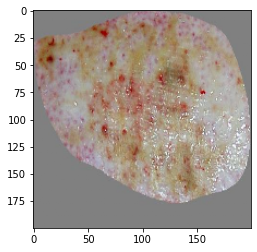

In [ ]:
# Test
#model = tf.keras.models.load_model("burn.model")
filepath = '/content/drive/MyDrive/CSC 514/Burns_BIP_US_database/Testing set/24.jpg'
test_img = prepare(filepath, IMG_SIZE, DIM)
test_img = test_img/255.0
prediction = model.predict(test_img)
pred_img_class = np.argmax(prediction[0]) + 1 # one added because python starts from class 0

plt.figure(figsize=(4,4))
plt.imshow(np.squeeze(test_img))

print("Class: ", pred_img_class, CATEGORIES[int(pred_img_class - 1)])

In [ ]:
# Evaluate
score = model.evaluate(Xt, yt_onehot, verbose=1) 

print('Test Loss:', score[0])
print('Test accuracy: ', score[1]*100)

3/3 [==============================] - 1s 282ms/step - loss: 2.5968 - accuracy: 0.4324
Test Loss: 2.596816301345825
Test accuracy:  43.24324429035187


In [ ]:
# Prediction
prediction = model.predict(Xt)

3/3 [==============================] - 0s 80ms/step


In [ ]:
pred = np.argmax(prediction, axis = 1)

In [ ]:
pred

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2,
       1, 2, 1, 1, 2, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 2, 0, 1, 1, 1, 2, 0,
       0, 1, 1, 1, 0, 1, 1, 2])

In [ ]:
yt

array([1, 2, 2, 0, 1, 0, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1,
       1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 1, 1,
       1, 2, 1, 0, 0, 2, 0, 1, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0])

In [ ]:
# Create confusion matrix
conf_mat = confusion_matrix(yt, pred)
print(conf_mat)

[[12 15  6]
 [ 6 18  3]
 [ 1 11  2]]


In [ ]:
# Pandas view of confusion matrix
df = pd.DataFrame(conf_mat, index = CATEGORIES, columns = CATEGORIES)
print(df)

             superficial  deep  full
superficial           12    15     6
deep                   6    18     3
full                   1    11     2
